In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd

import model_predict
from sklearn.model_selection import train_test_split

In [2]:
series, scaler = model_predict.read_data_series(scale=True, filter_early=True, file_index=1)

时间序列连贯


In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.cn = nn.Linear(12, 12)
        self.gru = nn.GRU(input_size + 1, hidden_size,
                          num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch, length, 3]
        x1 = x[:, :, 0].unsqueeze(2).permute(0, 2, 1)
        x1 = self.cn(x1)
        x = torch.cat([x, x1.permute(0, 2, 1)], dim=-1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out


model_parameters = {
    "input_size": 3, "hidden_size": 16, "num_layers": 1, "output_size": 1
}

In [4]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(GRUModel, model_parameters, series, epochs=600)

训练 GRUModel 模型
结果保存到： GRUModel_best.pth
Epoch [50/600], Learn Rate: 1.0000e-03, Training Loss: 0.0900, Validation Loss: 0.7204
Epoch [100/600], Learn Rate: 1.0000e-03, Training Loss: 0.0378, Validation Loss: 0.8843
Epoch [150/600], Learn Rate: 1.0000e-03, Training Loss: 0.0321, Validation Loss: 0.9008
Epoch [200/600], Learn Rate: 1.0000e-03, Training Loss: 0.0282, Validation Loss: 0.9459
Epoch [250/600], Learn Rate: 1.0000e-03, Training Loss: 0.0250, Validation Loss: 1.0100
Epoch [300/600], Learn Rate: 1.0000e-03, Training Loss: 0.0223, Validation Loss: 1.0839
Epoch [350/600], Learn Rate: 1.0000e-03, Training Loss: 0.0194, Validation Loss: 1.1554
Epoch [400/600], Learn Rate: 1.0000e-03, Training Loss: 0.0295, Validation Loss: 1.0977
Epoch [450/600], Learn Rate: 5.0000e-04, Training Loss: 0.0132, Validation Loss: 1.1791
Epoch [500/600], Learn Rate: 5.0000e-04, Training Loss: 0.0102, Validation Loss: 1.1805
Epoch [550/600], Learn Rate: 5.0000e-04, Training Loss: 0.0072, Validation Loss: 

从2019年9月开始后续数据推理
MSE: 1190.56
MAE: 25.73
R^2: -0.03
MAPE: 0.67


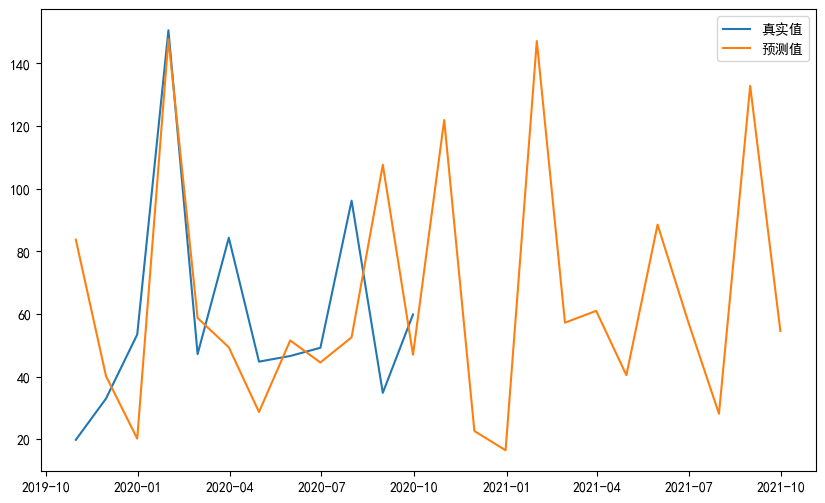

array([ 83.72016165,  40.12699032,  20.16070625, 147.74546505,
        58.69120294,  49.33549016,  28.67198494,  51.51977594,
        44.47839696,  52.52808061, 107.61588737,  46.95662299,
       121.92066481,  22.59117901,  16.45146616, 147.14354562,
        57.19905557,  60.97118475,  40.43946369,  88.49941152,
        57.90388633,  28.09256074, 132.80896317,  54.53879086])

In [5]:
model = model_predict.load_rnn_model_best(GRUModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler, last_months=12)